# Pale Blue Dot
Simulation of the Sun, Earth, Moon system. Generalizable to any number of objects in any dimensional space.

In [1]:
from __future__ import annotations

import numpy as np


GRAVITATIONAL_CONSTANT = 6.67430e-11
TIME_STEP_SEC = 24.0 * 60.0 * 60.0

class Obj:
    """An object represented as a point mass."""

    def __init__(self, mass: float, position: np.ndarray, velocity: np.ndarray = None) -> None:
        """
        Initilaize the object.
        Args:
            mass (float): mass of object (kg).
            position (np.ndarray): position vector of object (m).
            velocity (np.ndarray): initial velocity vector of object (m/s).
        """
        self.mass = mass
        self.position = position.astype(np.float64)
        self.velocity = velocity if velocity is not None else np.zeros_like(self.position)
        self.accel = np.zeros_like(self.position)

        self.position_history = [self.position.copy()]

    def step(self, time_step: float = TIME_STEP_SEC) -> None:
        """Update position and velocity. Add updated position to position history."""
        self.position += self.velocity * time_step
        self.position_history.append(self.position.copy())

        self.velocity += self.accel * time_step

    def calc_gravity_force(self, other: Obj) -> np.ndarray:
        """
        Calculate the gravitational force b/t the two objects.
        Returns the vector of the gravitational force from self to other.
        """
        dist_vector = other.position - self.position
        dist_sq = (dist_vector**2.0).sum()
        gravity_force = GRAVITATIONAL_CONSTANT * self.mass * other.mass / dist_sq
        unit_dist_vector = dist_vector / (dist_sq**0.5)
        gravity_vector = gravity_force * unit_dist_vector
        return gravity_vector

    def calc_accel(self, gravity_force: np.ndarray) -> np.ndarray:
        """Calculate the vector of acceleration given the vector of gravitational force in Ns."""
        return gravity_force / self.mass

    def zero_accel(self) -> None:
        """Zero the acceleration of the object."""
        self.accel = np.zeros_like(self.accel)

In [2]:
sun = Obj(mass=1.9891e30, position=np.array([0.0, 0.0]))
earth = Obj(mass=5.97219e24, position=np.array([0.0, 148.55e9]), velocity=np.array([29_784.8, 0.0]))
moon = Obj(mass=7.34767309e22, position=np.array([0.0, 148.55e9 + 384.4e6]), velocity=np.array([29_784.8 - 1_022.0, 0.0]))
objs = [sun, earth, moon]

SIMULATION_TIME_SEC = 365.0 * 24.0 * 60.0 * 60.0
for n_step in range(int(SIMULATION_TIME_SEC / TIME_STEP_SEC)):
    for obj in objs:
        obj.zero_accel()

    for i, obj in enumerate(objs[:-1]):
        for other_obj in objs[i + 1 :]:
            gravity_force = obj.calc_gravity_force(other_obj)
            obj.accel += obj.calc_accel(gravity_force)
            other_obj.accel += other_obj.calc_accel(-1.0 * gravity_force)

    for obj in objs:
        obj.step()

position_histories = np.stack([np.stack(obj.position_history) for obj in objs])  # n_obj, n_steps, n_coords

radii = np.array([6.96e8, 6.371e6, 1.74e6], dtype=np.float64)
radii = (radii / radii.max()) * 1_000.0


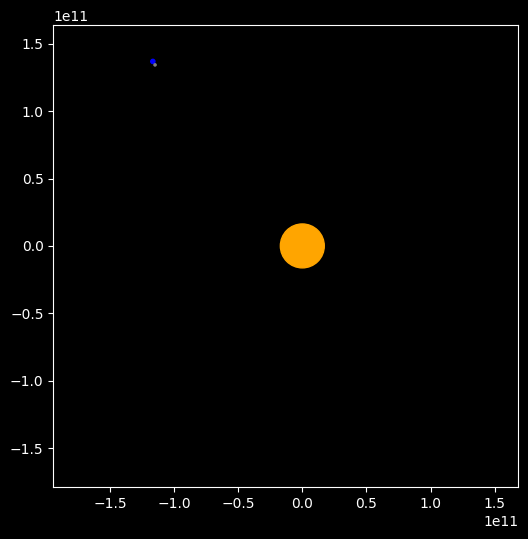

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim

from IPython.display import HTML

plt.style.use("dark_background")


# Plot position histories of objects.
fig, ax = plt.subplots(figsize=(6, 6))
img = ax.scatter(position_histories[:, 0, 0], position_histories[:, 0, 1], c=["orange", "blue", "gray"], s=radii)

ax.set_xlim(position_histories[:, :, 0].min() * 1.1, position_histories[:, :, 0].max() * 1.1)
ax.set_ylim(position_histories[:, :, 1].min() * 1.1, position_histories[:, :, 1].max() * 1.1)

def update(frame: int):
    """Update the image."""
    img.set_offsets(position_histories[:, frame, :])
    return img,

animation = anim.FuncAnimation(fig=fig, func=update, frames=position_histories.shape[1], blit=True)
HTML(animation.to_jshtml())

"Look again at that dot. That's here. That's home. That's us. On it everyone you love, everyone you know, everyone you ever heard of, every human being who ever was, lived out their lives. The aggregate of our joy and suffering, thousands of confident religions, ideologies, and economic doctrines, every hunter and forager, every hero and coward, every creator and destroyer of civilization, every king and peasant, every young couple in love, every mother and father, hopeful child, inventor and explorer, every teacher of morals, every corrupt politician, every "superstar," every "supreme leader," every saint and sinner in the history of our species lived there--on a mote of dust suspended in a sunbeam.

The Earth is a very small stage in a vast cosmic arena. Think of the rivers of blood spilled by all those generals and emperors so that, in glory and triumph, they could become the momentary masters of a fraction of a dot. Think of the endless cruelties visited by the inhabitants of one corner of this pixel on the scarcely distinguishable inhabitants of some other corner, how frequent their misunderstandings, how eager they are to kill one another, how fervent their hatreds.

Our posturings, our imagined self-importance, the delusion that we have some privileged position in the Universe, are challenged by this point of pale light. Our planet is a lonely speck in the great enveloping cosmic dark. In our obscurity, in all this vastness, there is no hint that help will come from elsewhere to save us from ourselves."

-Carl Sagan, *Pale Blue Dot*